### Weight of Evidence with Pandas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from feature_engine.encoding import PRatioEncoder

In [ ]:
ds = pd.read_csv('train.csv',usecols=[ 'Sex','Cabin', 'Embarked', 'Survived'])

In [ ]:
ds.head()

,Survived,Sex,Cabin,Embarked
0,0,male,NaN,S
1,1,female,C85,C
2,1,female,NaN,S
3,1,female,C123,S
4,0,male,NaN,S


In [ ]:
# lets replace NaN values for Cabin and Embarked with label 'Missing'
ds['Cabin'] = ds['Cabin'].fillna('Missing')
ds['Embarked'] = ds['Embarked'].fillna('Missing')

In [ ]:
ds.head()

,Survived,Sex,Cabin,Embarked
0,0,male,Missing,S
1,1,female,C85,C
2,1,female,Missing,S
3,1,female,C123,S
4,0,male,Missing,S


In [ ]:
# Now we extract the first letter of the cabin
# to create a simpler variable for practice

ds['Cabin'] = ds['Cabin'].astype(str).str[0]

In [ ]:
# let's remove the observations where Cabin = T as there are very few

ds = ds[ds['Cabin']!= 'T']
ds.shape

(890, 4)

In [ ]:
# Lets have a look at number of unique categories for each feature
for column in ds.columns:
  print(f"column {column} has {len(ds[column].unique())} unique categories")

column Survived has 2 unique categories
column Sex has 2 unique categories
column Cabin has 8 unique categories
column Embarked has 4 unique categories


In [ ]:
# let's have a look at unique labels
ds['Sex'].unique()

array(['male', 'female'], dtype=object)

In [ ]:
ds['Embarked'].unique()

array(['S', 'C', 'Q', 'Missing'], dtype=object)

In [ ]:
ds['Cabin'].unique()
# note that M is for Missing

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F'], dtype=object)

### Note: 
We select calculate the woe using the train set, and then use those mappings in the test set.

Note that in the pandas implementation, we need to keep the target in the training set


In [84]:
# Splitting the train and test set
X_train, X_test, y_train, y_test = train_test_split(
    ds[['Cabin', 'Sex', 'Embarked','Survived']],# this time we keep the target!!
    ds['Survived'],  
    test_size=0.3,  
    random_state=0) 

# print the shape
X_train.shape, X_test.shape

((623, 4), (267, 4))

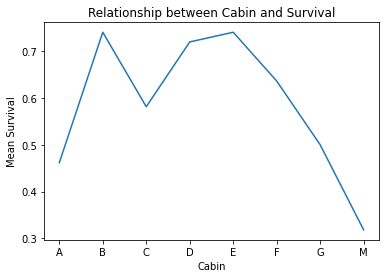

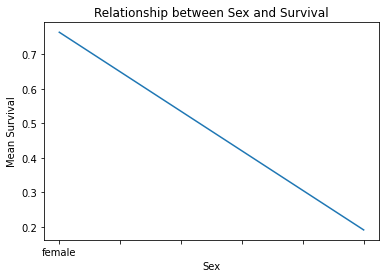

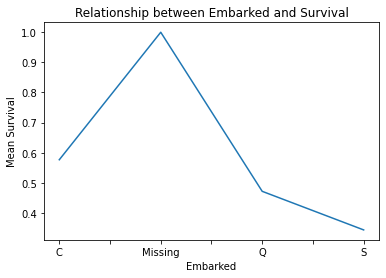

In [85]:
# let's plot the relationship of the categories with the target

for var in ['Cabin', 'Sex', 'Embarked']:
    fig = plt.figure()
    fig = X_train.groupby([var])['Survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survival')
    plt.show()

We can see that the relationship between the target and cabin and embarked goes up and down, depending on the category.



In [89]:
# let's calculate the proportion of passengers who survived
# over the total survivors, for each categories of cabin

# total survivors
total_survived = X_train['Survived'].sum()
print("total number of people that survived: ", total_survived)

# percentage of passenges who survived, from total survivors
# per category of cabin
survived = X_train.groupby(['Cabin'])['Survived'].sum() / total_survived

# lets print the values
survived

total number of people that survived:  248


Cabin
A    0.024194
B    0.080645
C    0.100806
D    0.072581
E    0.080645
F    0.028226
G    0.004032
M    0.608871
Name: Survived, dtype: float64

In [90]:
# let's calculate the proportion of passengers who did not survive
# over the total passengers who didn't, for each categires of cabin

# total passengers who did not survive
total_non_survived = len(X_train) - X_train['Survived'].sum()

# let's create a flag for passenges who did not survive
X_train['non_survived'] = np.where(X_train['Survived'] == 1, 0, 1)

# now let's calculate the % of passengers who did not survive
# per category of cabin
non_survived = X_train.groupby(
    ['Cabin'])['non_survived'].sum() / total_non_survived

# lets print te values
non_survived

Cabin
A    0.018667
B    0.018667
C    0.048000
D    0.018667
E    0.018667
F    0.010667
G    0.002667
M    0.864000
Name: non_survived, dtype: float64

In [91]:
#  let's combine those 2 series in a dataframe and calculate the WoE

# let's concatenate the series in a dataframe
prob_df = pd.concat([survived, non_survived], axis=1)

# let's calculate the Weight of Evidence
prob_df['WoE'] = np.log(prob_df['Survived']/prob_df['non_survived'])

# lets observe the dataframe
prob_df

,Survived,non_survived,WoE
Cabin,,,
A,0.024194,0.018667,0.259347
B,0.080645,0.018667,1.463319
C,0.100806,0.048000,0.742001
D,0.072581,0.018667,1.357959
E,0.080645,0.018667,1.463319
F,0.028226,0.010667,0.973113
G,0.004032,0.002667,0.413497
M,0.608871,0.864000,-0.349966


In [92]:
# lets store the WoE value to a dictionary for mapping

ordered_labels = prob_df['WoE'].to_dict()

# print the dictionary
ordered_labels

{'A': 0.25934659997817017,
 'B': 1.4633194043041062,
 'C': 0.7420013467774647,
 'D': 1.3579588886462801,
 'E': 1.4633194043041062,
 'F': 0.9731130677408513,
 'G': 0.4134972798054287,
 'M': -0.3499663991719764}

In [95]:
# let's view the result

X_train.head(10)

,Cabin,Sex,Embarked,Survived,non_survived
64,-0.349966,male,C,0,1
709,-0.349966,male,C,1,0
52,1.357959,female,C,1,0
387,-0.349966,female,S,1,0
124,1.357959,male,S,0,1
579,-0.349966,male,S,1,0
550,0.742001,male,C,1,0
118,1.463319,male,C,0,1
12,-0.349966,male,S,0,1
157,-0.349966,male,S,0,1


In [96]:
# Lets create a functions that contains the method for transformation

def func_WoE_mappings(ds, feature, target):
    # copy of the original dataframe, so we do not accidentally
    # modify it
    tmp = ds.copy()

    # total positive class
    total_pos = ds[target].sum()

    # total negative class
    total_neg = len(ds) - ds[target].sum()

    # non target
    tmp['non-target'] = 1 - tmp[target]

    # % of positive class per category, respect to total positive class
    pos_perc = tmp.groupby([feature])[target].sum() / total_pos

    # % of negative class per category, respect to total negative class
    neg_perc = tmp.groupby([feature])['non-target'].sum() / total_neg

    # let's concatenate
    prob_tmp = pd.concat([pos_perc, neg_perc], axis=1)

    # let's calculate the Weight of Evidence
    prob_tmp['woe'] = np.log(prob_tmp[target]/prob_tmp['non-target'])

    return prob_tmp['woe'].to_dict()


def func_encode(train, test, feature, ordinal_mapping):

    train[feature] = train[feature].map(ordinal_mapping)

    test[feature] = test[feature].map(ordinal_mapping)

In [97]:
# lets loop over the remaining categories and encode them too.

for feature in ['Sex', 'Embarked']:

    mappings = func_WoE_mappings(X_train, feature, 'Survived')

    func_encode(X_train, X_test, feature, mappings)

In [98]:
# let's observe the result

X_train.head()

,Cabin,Sex,Embarked,Survived,non_survived
64,-0.349966,-1.030321,0.722233,0,1
709,-0.349966,-1.030321,0.722233,1,0
52,1.357959,1.590700,0.722233,1,0
387,-0.349966,1.590700,-0.234039,1,0
124,1.357959,-1.030321,-0.234039,0,1


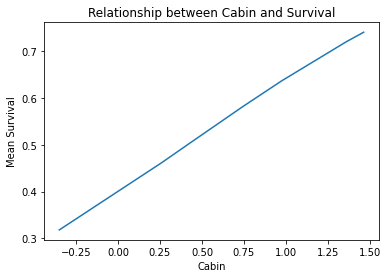

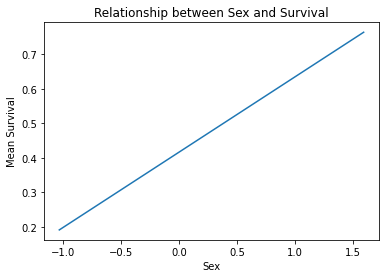

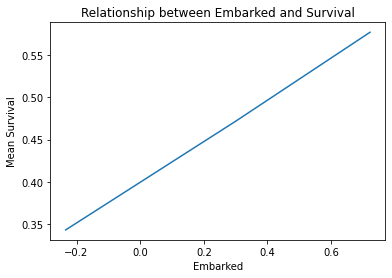

In [99]:
# let's plot the relationship of the categories with the target after encoding

for var in ['Cabin', 'Sex', 'Embarked']:
    fig = plt.figure()
    fig = X_train.groupby([var])['Survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survival')
    plt.show()

Note the monotonic relationships between the mean target and the categories. In the train set.


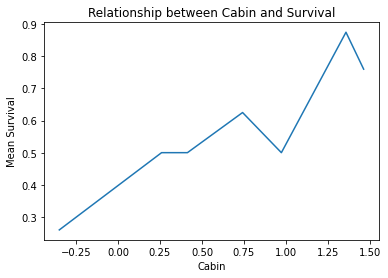

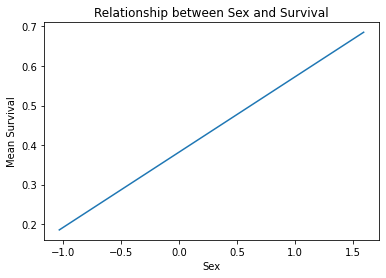

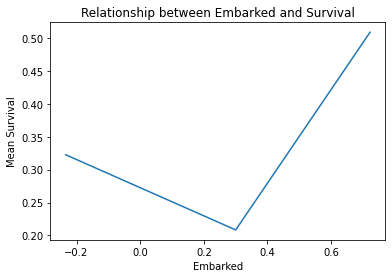

In [100]:
# let's plot the relationship of the categories with the target after encoding
# for test set
for var in ['Cabin', 'Sex', 'Embarked']:
    fig = plt.figure()
    fig = X_test.groupby([var])['Survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survival')
    plt.show()

The monotonic relationship does not hold when encoding the categorical variables in the test set. This could mean that the categories are not informative of the target or the proportion of survivors is not homogeneous between in the categories in the train and test sets.

In situations like this, we could try grouping rare labels into a joint category , before applying the Weight of evidence transformation.

### Note
Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand. 

**In addition, it will create NA or Inf if any of the 2 terms in the ratio of the WoE formula are 0**




### Advantages
- quick
- returns pandas dataframe

### Limitations of pandas:
- it does not preserve information from train data to propagate to test data